# Ungraded Lab: Using a Simple RNN for forecasting

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Sequences_Time_Series_and_Prediction/Week3/Labs/C4_W3_Lab_1_RNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
from keras import Sequential, Input, layers, callbacks, optimizers, losses, metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-14 11:21:01.957551: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
        time (array of int) - contains the time steps
        series (array of int) - contains the measurements for each time step
        format - line style when plotting the graph
        start - first time step to plot
        end - last time step to plot
    """
    sns.set_style("whitegrid")

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
        # Plot the time series data
        plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
        time (array of int) - contains the time steps
        slope (float) - determines the direction and steepness of the line

    Returns:
        series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
        season_time (array of float) - contains the measurements per time step

    Returns:
        data_pattern (array of float) -  contains revised measurement values according to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                            np.cos(season_time * 2 * np.pi),
                            1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
        time (array of int) - contains the time steps
        period (int) - number of time steps before the pattern repeats
        amplitude (int) - peak measured value in a period
        phase (int) - number of time steps to shift the measured values

    Returns:
        data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
        time (array of int) - contains the time steps
        noise_level (float) - scaling factor for the generated signal
        seed (int) - number generator seed for repeatability

    Returns:
        noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

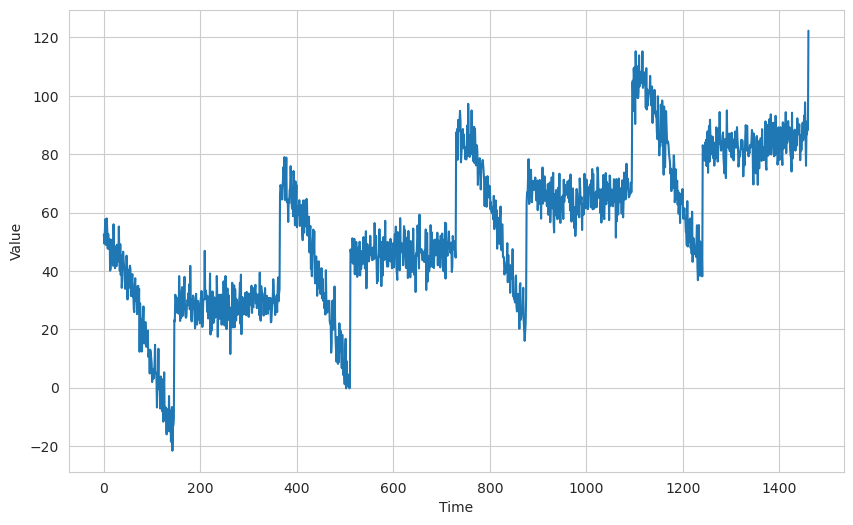

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-06-14 11:21:04.348722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2155 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [8]:
# Print shapes of feature and label
for window in dataset.take(1):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


2024-06-14 11:21:04.485559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Build the Model

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routes its output back to the input. You will stack two of these layers in your model so the first one should have `return_sequences` set to `True`.

As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Normally, you can just a have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [9]:
# Build the Model
model_tune = Sequential([Input(shape=(window_size,)),
                         layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                         layers.SimpleRNN(40, return_sequences=True),
                         layers.SimpleRNN(40),
                         layers.Dense(1),
                         layers.Lambda(lambda x: x * 100.0)])

# Print the model summary
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [10]:
# Set the learning rate scheduler
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


I0000 00:00:1718385665.645039   20066 service.cc:145] XLA service 0x55b4204ef4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718385665.645061   20066 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-14 11:21:05.679696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-14 11:21:05.773888: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


     30/Unknown 2s 4ms/step - loss: 61.5307

I0000 00:00:1718385666.445739   20066 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 61.4930 - learning_rate: 1.0000e-08
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.6565 - learning_rate: 1.1220e-08
Epoch 3/100


2024-06-14 11:21:07.271326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:07.271355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:07.271372: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
/home/luis-mendoza/anaconda3/envs/TDPC_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-14 11:21:07.428116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abort

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.4616 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.8583 - learning_rate: 1.4125e-08
Epoch 5/100


2024-06-14 11:21:07.585415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:07.585440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:07.585449: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:07.585457: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:07.740049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:07.740089: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53.8939 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.6168 - learning_rate: 1.7783e-08
Epoch 7/100


2024-06-14 11:21:07.894384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:07.894443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:07.894452: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:07.894460: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:08.053274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:08.053332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.2668 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.8189 - learning_rate: 2.2387e-08
Epoch 9/100


2024-06-14 11:21:08.205574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:08.205600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:08.205610: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:08.205619: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:08.362703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:08.362733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41.4981 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.1800 - learning_rate: 2.8184e-08
Epoch 11/100


2024-06-14 11:21:08.565427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:08.565452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:08.565461: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:08.565469: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:08.718189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:08.718211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.4907 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.1869 - learning_rate: 3.5481e-08
Epoch 13/100


2024-06-14 11:21:08.869063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:08.869098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:08.869106: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:08.869113: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:09.021454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:09.021477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.1962 - learning_rate: 3.9811e-08
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.3476 - learning_rate: 4.4668e-08
Epoch 15/100


2024-06-14 11:21:09.174215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:09.174238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:09.174247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:09.174255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:09.327875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:09.327910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.6503 - learning_rate: 5.0119e-08
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.2858 - learning_rate: 5.6234e-08
Epoch 17/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 18.9351

2024-06-14 11:21:09.485065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:09.485125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:09.485134: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:09.485142: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:09.634587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:09.634609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.1030 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4729 - learning_rate: 7.0795e-08
Epoch 19/100


2024-06-14 11:21:09.786925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:09.786953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:09.786968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:09.941179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:09.941202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:09.941214: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.3951 - learning_rate: 7.9433e-08
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.7191 - learning_rate: 8.9125e-08
Epoch 21/100


2024-06-14 11:21:10.094217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:10.094247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:10.094259: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:10.094270: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:10.246437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:10.246463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.8804 - learning_rate: 1.0000e-07
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4033 - learning_rate: 1.1220e-07
Epoch 23/100


2024-06-14 11:21:10.400556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:10.400598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:10.400609: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:10.400620: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:10.576785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:10.576813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1018 - learning_rate: 1.2589e-07
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.7736 - learning_rate: 1.4125e-07
Epoch 25/100


2024-06-14 11:21:10.732984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:10.733008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:10.733019: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:10.733028: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:10.885761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:10.885800: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.5521 - learning_rate: 1.5849e-07
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.7207 - learning_rate: 1.7783e-07
Epoch 27/100


2024-06-14 11:21:11.037310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:11.037335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:11.037345: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:11.037353: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:11.193441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:11.193468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.9551 - learning_rate: 1.9953e-07
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.6456 - learning_rate: 2.2387e-07
Epoch 29/100


2024-06-14 11:21:11.361312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:11.361338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:11.361353: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:11.513444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:11.513473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:11.513499: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.8704 - learning_rate: 2.5119e-07
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2895 - learning_rate: 2.8184e-07
Epoch 31/100


2024-06-14 11:21:11.666640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:11.666698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:11.666709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:11.666720: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:11.820041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:11.820081: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.0997 - learning_rate: 3.1623e-07
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.9547 - learning_rate: 3.5481e-07
Epoch 33/100


2024-06-14 11:21:11.976132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:11.976154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:11.976167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:11.976177: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:12.129341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:12.129370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.0936 - learning_rate: 3.9811e-07
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.0129 - learning_rate: 4.4668e-07
Epoch 35/100


2024-06-14 11:21:12.280821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:12.280848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:12.280858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:12.280867: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:12.440822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:12.440860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.0249 - learning_rate: 5.0119e-07
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9478 - learning_rate: 5.6234e-07
Epoch 37/100


2024-06-14 11:21:12.593950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:12.593993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:12.594002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:12.594011: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:12.772697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:12.772735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.3394 - learning_rate: 6.3096e-07
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7330 - learning_rate: 7.0795e-07
Epoch 39/100


2024-06-14 11:21:12.926387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:12.926412: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:12.926418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:13.083825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:13.083850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:13.083862: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4123 - learning_rate: 7.9433e-07
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6934 - learning_rate: 8.9125e-07
Epoch 41/100


2024-06-14 11:21:13.236626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:13.236675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:13.236693: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:13.236705: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:13.392152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:13.392213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7856 - learning_rate: 1.0000e-06
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2035 - learning_rate: 1.1220e-06
Epoch 43/100


2024-06-14 11:21:13.543566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:13.543588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:13.543597: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:13.543604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:13.696699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:13.696727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9541 - learning_rate: 1.2589e-06
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4709 - learning_rate: 1.4125e-06
Epoch 45/100


2024-06-14 11:21:13.852498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:13.852523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:13.852532: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:13.852540: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:14.009870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:14.009901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4402 - learning_rate: 1.5849e-06
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9494 - learning_rate: 1.7783e-06
Epoch 47/100


2024-06-14 11:21:14.166953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:14.166974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:14.166983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:14.166990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:14.320929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:14.320956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4845 - learning_rate: 1.9953e-06
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0116 - learning_rate: 2.2387e-06
Epoch 49/100


2024-06-14 11:21:14.476783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:14.476807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:14.476816: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:14.476824: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:14.634000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:14.634025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1932 - learning_rate: 2.5119e-06
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1615 - learning_rate: 2.8184e-06
Epoch 51/100


2024-06-14 11:21:14.787716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:14.787739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:14.787748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:14.787756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:14.942670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:14.942693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6533 - learning_rate: 3.1623e-06
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1596 - learning_rate: 3.5481e-06
Epoch 53/100


2024-06-14 11:21:15.136023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:15.136050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:15.136062: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:15.136072: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:15.290888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:15.290915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8495 - learning_rate: 3.9811e-06
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5987 - learning_rate: 4.4668e-06
Epoch 55/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.8597

2024-06-14 11:21:15.444287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:15.444312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:15.444322: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:15.444333: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:15.592916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:15.592939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3563 - learning_rate: 5.0119e-06
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4197 - learning_rate: 5.6234e-06
Epoch 57/100


2024-06-14 11:21:15.743623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:15.743663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:15.743690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:15.898269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:15.898292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:15.898361: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6162 - learning_rate: 6.3096e-06
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5634 - learning_rate: 7.0795e-06
Epoch 59/100


2024-06-14 11:21:16.052824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:16.052880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:16.052889: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:16.052898: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:16.204447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:16.204469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7401 - learning_rate: 7.9433e-06
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8018 - learning_rate: 8.9125e-06
Epoch 61/100


2024-06-14 11:21:16.360153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:16.360179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:16.360201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:16.360208: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:16.516923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:16.516965: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5918 - learning_rate: 1.0000e-05
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3046 - learning_rate: 1.1220e-05
Epoch 63/100


2024-06-14 11:21:16.670134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:16.670160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:16.670183: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:16.670191: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:16.824211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:16.824278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3627 - learning_rate: 1.2589e-05
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1672 - learning_rate: 1.4125e-05
Epoch 65/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.3359

2024-06-14 11:21:16.976796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:16.976821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:16.976830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:16.976838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:17.126908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:17.126968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1600 - learning_rate: 1.5849e-05
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1860 - learning_rate: 1.7783e-05
Epoch 67/100


2024-06-14 11:21:17.308899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:17.308921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:17.308929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:17.308937: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:17.463961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:17.463989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2388 - learning_rate: 1.9953e-05
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4397 - learning_rate: 2.2387e-05
Epoch 69/100


2024-06-14 11:21:17.616847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:17.616869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:17.616877: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:17.616884: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:17.770347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:17.770374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5484 - learning_rate: 2.5119e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4500 - learning_rate: 2.8184e-05
Epoch 71/100


2024-06-14 11:21:17.927667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:17.927692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:17.927701: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:17.927708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:18.083829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:18.083852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6754 - learning_rate: 3.1623e-05
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9754 - learning_rate: 3.5481e-05
Epoch 73/100


2024-06-14 11:21:18.236353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:18.236384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:18.236398: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:18.236411: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:18.393284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:18.393309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6837 - learning_rate: 3.9811e-05
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9688 - learning_rate: 4.4668e-05
Epoch 75/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.6664

2024-06-14 11:21:18.543923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:18.543946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:18.543955: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:18.543963: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:18.693026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:18.693072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0884 - learning_rate: 5.0119e-05
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6645 - learning_rate: 5.6234e-05
Epoch 77/100


2024-06-14 11:21:18.844659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:18.844684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:18.844709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:18.844739: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:18.999420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:18.999443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4038 - learning_rate: 6.3096e-05
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1162 - learning_rate: 7.0795e-05
Epoch 79/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.6088

2024-06-14 11:21:19.156000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:19.156057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:19.156090: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:19.307009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:19.307032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:19.307040: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4952 - learning_rate: 7.9433e-05
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.6930 - learning_rate: 8.9125e-05
Epoch 81/100


2024-06-14 11:21:19.463239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:19.463266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:19.463275: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:19.463283: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:19.641543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:19.641567: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.0790 - learning_rate: 1.0000e-04
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.6381 - learning_rate: 1.1220e-04
Epoch 83/100


2024-06-14 11:21:19.794138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:19.794164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:19.794175: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:19.794185: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:19.950147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:19.950188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.4279 - learning_rate: 1.2589e-04
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.1338 - learning_rate: 1.4125e-04
Epoch 85/100


2024-06-14 11:21:20.104418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:20.104443: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:20.104492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:20.257434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:20.257473: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:20.257506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.5689 - learning_rate: 1.5849e-04
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.7079 - learning_rate: 1.7783e-04
Epoch 87/100


2024-06-14 11:21:20.412342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:20.412373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:20.412387: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:20.412397: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:20.565150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:20.565189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.2825 - learning_rate: 1.9953e-04
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.9884 - learning_rate: 2.2387e-04
Epoch 89/100


2024-06-14 11:21:20.719432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:20.719462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:20.719478: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:20.872586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:20.872610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:20.872621: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.2676 - learning_rate: 2.5119e-04
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.0864 - learning_rate: 2.8184e-04
Epoch 91/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 17.0964

2024-06-14 11:21:21.026344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:21.026365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:21.026379: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:21.177322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:21.177349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:21.177357: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.5270 - learning_rate: 3.1623e-04
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.7780 - learning_rate: 3.5481e-04
Epoch 93/100


2024-06-14 11:21:21.328041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:21.328063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:21.328071: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:21.328078: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:21.482564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:21.482617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.7653 - learning_rate: 3.9811e-04
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.3475 - learning_rate: 4.4668e-04
Epoch 95/100


2024-06-14 11:21:21.633961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:21.634018: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:21.634028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:21.815136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:21.815159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:21.815168: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.6090 - learning_rate: 5.0119e-04
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.0125 - learning_rate: 5.6234e-04
Epoch 97/100


2024-06-14 11:21:21.967121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:21.967143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:21.967151: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:21.967161: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:22.118548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:22.118572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.0532 - learning_rate: 6.3096e-04
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.2276 - learning_rate: 7.0795e-04
Epoch 99/100


2024-06-14 11:21:22.270244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:22.270268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:22.270284: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:22.425279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:22.425338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:22.425346: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.6494 - learning_rate: 7.9433e-04
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.8173 - learning_rate: 8.9125e-04


2024-06-14 11:21:22.577061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:22.577083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:22.577091: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:22.577102: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:22.729546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:22.729578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

You can visualize the results and pick an optimal learning rate.

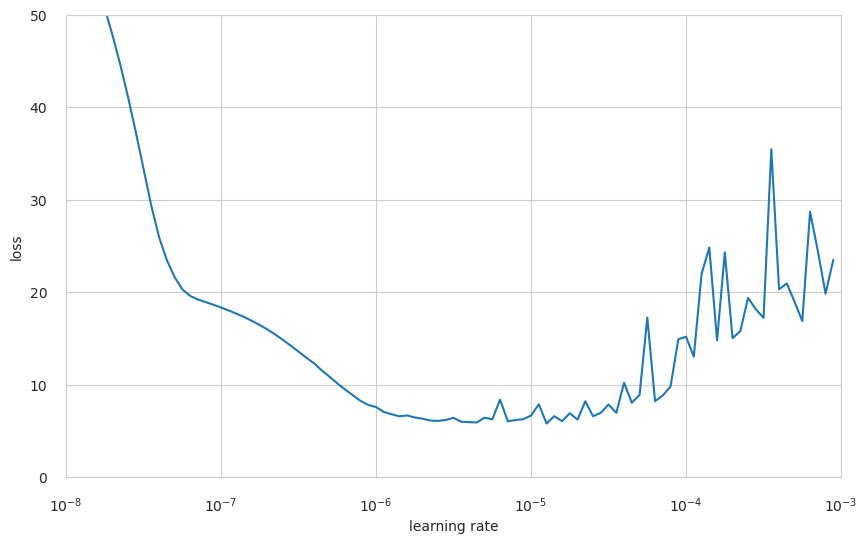

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

You can change the boundaries of the graph if you want to zoom in. The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

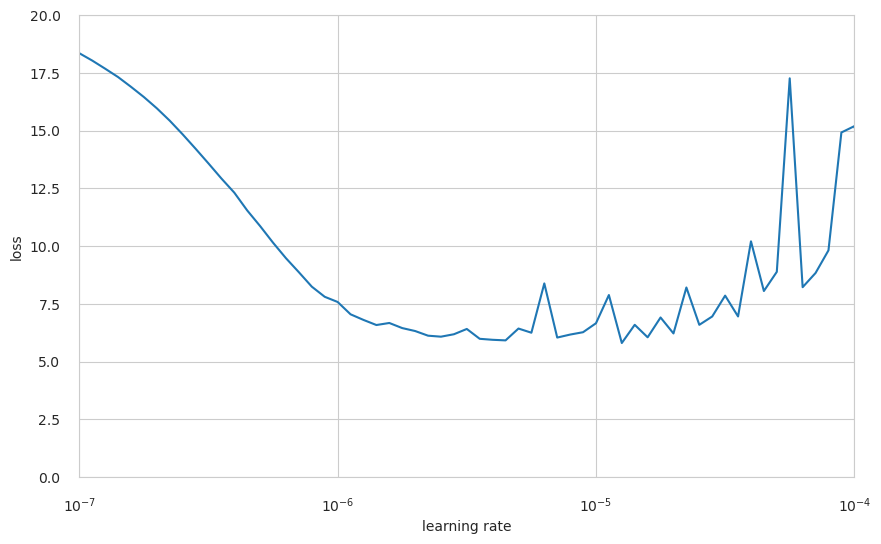

In [12]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

## Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to `1e-6`by default but feel free to change it.

In [13]:
# Build the model
model = Sequential([Input(shape=(window_size,)),
                    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
                    layers.SimpleRNN(40, return_sequences=True),
                    layers.SimpleRNN(40),
                    layers.Dense(1),
                    layers.Lambda(lambda x: x * 100.0)])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 48.9967 - mae: 49.4958
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.4342 - mae: 13.9291
Epoch 3/100


2024-06-14 11:21:25.595881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:25.595950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:25.595962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:25.595970: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:25.769206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:25.769230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8750 - mae: 9.3619
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1006 - mae: 7.5766
Epoch 5/100


2024-06-14 11:21:25.941537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:25.941578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:25.941588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:25.941595: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:26.095523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:26.095554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3702 - mae: 6.8494
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4733 - mae: 6.9582
Epoch 7/100


2024-06-14 11:21:26.251056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:26.251079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:26.251088: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:26.251095: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:26.406915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:26.406942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0582 - mae: 6.5352
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7459 - mae: 6.2245
Epoch 9/100


2024-06-14 11:21:26.561551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:26.561640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:21:26.717410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:26.717455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:26.717464: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:26.717471: I tensorflow/core/framework/local_re

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2259 - mae: 6.7043
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7700 - mae: 6.2500
Epoch 11/100


2024-06-14 11:21:26.874733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:26.874761: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:26.874791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:27.030309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:27.030337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:27.030349: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3538 - mae: 6.8398
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9728 - mae: 6.4481
Epoch 13/100


2024-06-14 11:21:27.185060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:27.185096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:27.185124: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:27.185132: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:27.339491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:27.339520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8746 - mae: 6.3535
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4124 - mae: 5.8927
Epoch 15/100


2024-06-14 11:21:27.495524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:27.495558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:27.495569: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:27.495579: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:27.649962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:27.649983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4093 - mae: 5.8893
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6575 - mae: 6.1343
Epoch 17/100


2024-06-14 11:21:27.847133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:27.847156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:27.847165: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:27.847173: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:28.005287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:28.005310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4731 - mae: 5.9493
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9049 - mae: 6.3879
Epoch 19/100


2024-06-14 11:21:28.160949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:28.160977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:28.160990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:28.161000: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:28.319606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:28.319632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6502 - mae: 6.1296
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9911 - mae: 5.4645
Epoch 21/100


2024-06-14 11:21:28.479002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:28.479025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:28.479034: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:28.479042: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:28.633392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:28.633419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6493 - mae: 6.1278
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6702 - mae: 6.1460
Epoch 23/100


2024-06-14 11:21:28.789924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:28.789946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:28.789954: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:28.789962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:28.947051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:28.947076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7331 - mae: 6.2139
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6896 - mae: 6.1676
Epoch 25/100


2024-06-14 11:21:29.102865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:29.102894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:29.102906: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:29.102913: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:29.265055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:29.265079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0893 - mae: 5.5670
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3471 - mae: 5.8235
Epoch 27/100


2024-06-14 11:21:29.423064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:29.423087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:29.423102: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:29.580628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:29.580664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:29.580693: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5551 - mae: 6.0348
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0667 - mae: 5.5447
Epoch 29/100


2024-06-14 11:21:29.737433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:29.737505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:29.737538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:29.737550: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:29.892111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:29.892137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4511 - mae: 5.9317
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8886 - mae: 5.3686
Epoch 31/100


2024-06-14 11:21:30.088527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:30.088554: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:30.088590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:30.243429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:30.243451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:30.243463: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3950 - mae: 5.8729
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3922 - mae: 5.8722
Epoch 33/100


2024-06-14 11:21:30.403248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:30.403276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:30.403285: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:30.403293: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:30.556784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:30.556810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2995 - mae: 5.7819
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5738 - mae: 6.0516
Epoch 35/100


2024-06-14 11:21:30.714108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:30.714133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:30.714141: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:30.714149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:30.866912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:30.866950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2415 - mae: 5.7208
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5199 - mae: 5.9987
Epoch 37/100


2024-06-14 11:21:31.023531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:31.023590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:31.023599: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:31.023606: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:31.178027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:31.178061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3384 - mae: 5.8222
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0390 - mae: 5.5162
Epoch 39/100


2024-06-14 11:21:31.333249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:31.333275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:31.333283: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:31.333292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:31.492337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:31.492371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4992 - mae: 5.9771
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4684 - mae: 5.9478
Epoch 41/100


2024-06-14 11:21:31.649917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:31.649944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:31.649953: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:31.649960: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:31.806736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:31.806760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3361 - mae: 5.8142
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4023 - mae: 5.8757
Epoch 43/100


2024-06-14 11:21:31.963353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:31.963377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:31.963385: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:31.963393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:32.152354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:32.152413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1495 - mae: 5.6300
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0099 - mae: 5.4882
Epoch 45/100


2024-06-14 11:21:32.311352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:32.311380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:32.311392: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:32.311405: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:32.466138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:32.466207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2035 - mae: 5.6753
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3857 - mae: 5.8664
Epoch 47/100


2024-06-14 11:21:32.627360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:32.627391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:32.627403: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:32.627414: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:32.783143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:32.783168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2962 - mae: 5.7787
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2718 - mae: 5.7487
Epoch 49/100


2024-06-14 11:21:32.940660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:32.940683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:32.940692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:32.940699: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:33.095358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:33.095387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3994 - mae: 5.8780
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0094 - mae: 5.4825
Epoch 51/100


2024-06-14 11:21:33.257568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:33.257635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:21:33.413753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:33.413777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:33.413785: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:33.413792: I tensorflow/core/framework/local_re

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1176 - mae: 5.5906
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0310 - mae: 5.5079
Epoch 53/100


2024-06-14 11:21:33.570331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:33.570374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:33.570383: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:33.570391: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:33.724807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:33.724829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9440 - mae: 5.4185
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3667 - mae: 5.8417
Epoch 55/100


2024-06-14 11:21:33.880141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:33.880163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:33.880173: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:33.880181: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:34.036285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:34.036309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0164 - mae: 5.4976
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2730 - mae: 5.7523
Epoch 57/100


2024-06-14 11:21:34.239098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:34.239124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:34.239136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:34.239147: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:34.396339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:34.396368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9846 - mae: 5.4609
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8932 - mae: 5.3715
Epoch 59/100


2024-06-14 11:21:34.556182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:34.556204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:34.556212: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:34.556220: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:34.713628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:34.713653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0090 - mae: 5.4905
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0246 - mae: 5.5002
Epoch 61/100


2024-06-14 11:21:34.873016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:34.873037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:34.873048: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:34.873059: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:35.032975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:35.033001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0823 - mae: 5.5505
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1227 - mae: 5.6032
Epoch 63/100


2024-06-14 11:21:35.194982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:35.195015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:35.195030: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:35.195046: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:35.369204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:35.369235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3272 - mae: 5.8060
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7637 - mae: 5.2424
Epoch 65/100


2024-06-14 11:21:35.529536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:35.529559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:35.529568: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:35.529576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:35.685734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:35.685766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7559 - mae: 5.2282
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1925 - mae: 5.6669
Epoch 67/100


2024-06-14 11:21:35.839447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:35.839469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:35.839478: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:35.839485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:35.994561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:35.994589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2835 - mae: 5.7612
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0305 - mae: 5.5100
Epoch 69/100


2024-06-14 11:21:36.170988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:36.171011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:36.171033: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:36.171041: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:36.325642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:36.325664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0825 - mae: 5.5630
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6619 - mae: 5.1358
Epoch 71/100


2024-06-14 11:21:36.480459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:36.480516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:36.480544: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:36.480552: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:36.635516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:36.635539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7023 - mae: 5.1822
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7558 - mae: 5.2356
Epoch 73/100


2024-06-14 11:21:36.790212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:36.790253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:36.790283: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:36.790291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:36.947128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:36.947155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1254 - mae: 5.5984
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4319 - mae: 5.9120
Epoch 75/100


2024-06-14 11:21:37.101833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:37.101863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:37.101874: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:37.101884: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:37.257638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:37.257664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7414 - mae: 5.2114
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2886 - mae: 5.7639
Epoch 77/100


2024-06-14 11:21:37.413904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:37.413933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:37.413944: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:37.413956: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:37.570860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:37.570898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5755 - mae: 5.0525
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3107 - mae: 5.7877
Epoch 79/100


2024-06-14 11:21:37.729922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:37.729980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:37.729990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:37.729998: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:37.883788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:37.883845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9738 - mae: 5.4496
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7126 - mae: 5.1928
Epoch 81/100


2024-06-14 11:21:38.040063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:38.040087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:38.040095: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:38.040102: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:38.191713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:38.191784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8372 - mae: 5.3133
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0508 - mae: 5.5314
Epoch 83/100


2024-06-14 11:21:38.381922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:38.381983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:21:38.539606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:38.539642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:38.539654: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:38.539665: I tensorflow/core/framework/local_re

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6752 - mae: 5.1435
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6326 - mae: 5.1099
Epoch 85/100


2024-06-14 11:21:38.693498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:38.693526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 11:21:38.846767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:38.846830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:38.846842: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:38.846853: I tensorflow/core/framework/local_re

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9310 - mae: 5.4101
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7212 - mae: 5.1998
Epoch 87/100


2024-06-14 11:21:39.002114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:39.002136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:39.002153: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:39.156280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:39.156342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:39.156359: I tensorflow/core/framework/local_rend

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9607 - mae: 5.4382
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0392 - mae: 5.5137
Epoch 89/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.0342 - mae: 3.4979

2024-06-14 11:21:39.309992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:39.310015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:39.310026: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:39.310036: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:39.463565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:39.463591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5650 - mae: 5.0391
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7373 - mae: 5.2155
Epoch 91/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.9083 - mae: 6.3783

2024-06-14 11:21:39.616056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:39.616084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:39.616094: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:39.616101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:39.767440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:39.767483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9687 - mae: 5.4465
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3370 - mae: 5.8126
Epoch 93/100


2024-06-14 11:21:39.923646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:39.923670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:39.923681: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:39.923692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:40.080186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:40.080209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9260 - mae: 5.4029
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7174 - mae: 5.1922
Epoch 95/100


2024-06-14 11:21:40.235530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:40.235552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:40.235574: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:40.235600: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:40.388348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:40.388374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7751 - mae: 5.2505
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1068 - mae: 5.5832
Epoch 97/100


2024-06-14 11:21:40.583893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:40.583917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:40.583941: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:40.583969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:40.739087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:40.739111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7286 - mae: 5.1975
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7219 - mae: 5.1957
Epoch 99/100


2024-06-14 11:21:40.895888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:40.895914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:40.895942: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:40.895950: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:41.052263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:41.052322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0307 - mae: 5.5038
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0014 - mae: 5.4748


2024-06-14 11:21:41.204276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:41.204299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 11:21:41.204308: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17410410192653400884
2024-06-14 11:21:41.204314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 440900125429278672
2024-06-14 11:21:41.358746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 11:21:41.358787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

## Model Prediction

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. You can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

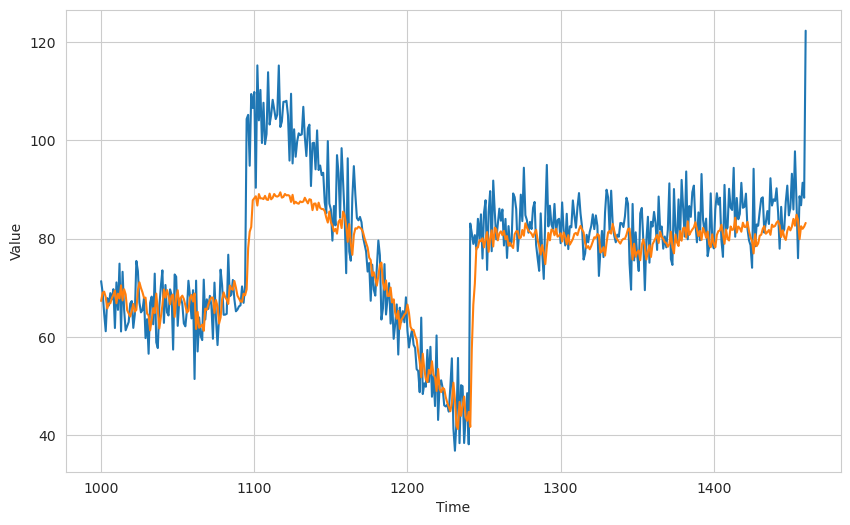

In [14]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, you can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. You will notice that it almost mirrors the `windowed_dataset()` function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
        model (TF Keras Model) - model that accepts data windows
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the window
        batch_size (int) - the batch size

    Returns:
        forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

You can run the function below to use the function. Notice that the predictions are generated almost instantly.

*Note: You might notice that the first line slices the `series` at `split_time - window_size:-1` which is a bit different from the slower for-loop code. That is because we want the model to have its last prediction to align with the last point of the validation set (i.e. `t=1460`). You were able to do that with the slower for-loop code by specifying the for-loop's `range()`. With the more efficient function above, you don't have that mechanism so you instead just remove the last point when slicing the `series`. If you don't, then the function will generate a prediction at `t=1461` which is outside the validation set range.*

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


2024-06-14 11:22:02.263629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


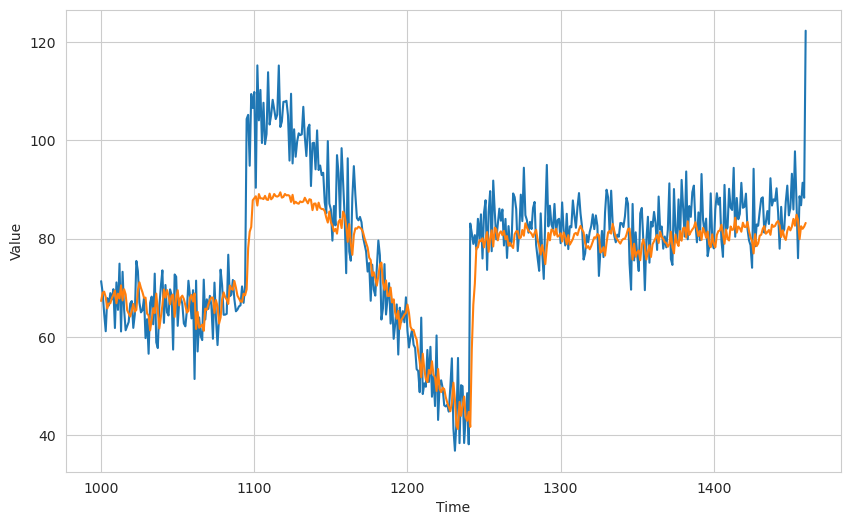

In [16]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the MSE and MAE. You can compare the results here when using other RNN architectures which you'll do in the next lab.

In [17]:
# Compute the MSE and MAE
print(metrics.mean_squared_error(x_valid, results).numpy())
print(metrics.mean_absolute_error(x_valid, results).numpy())

71.89047
6.16039
